In [107]:
import numpy as np
import pandas as pd
import pylab as pl
import statsmodels.api as sm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Loading data and understanding the python datacube
mtaRides = np.load("MTA_Fare.npy")
mtaRides.shape

(600, 23, 194)

The mtaRides variable is a datacube which consist of swiping data of 600 stations, 23 cardtypes and 194 weeks from 05/21/2010 to 02/21/2014

In [4]:
#Reading the datacube
mtaRides

array([[[56961, 64703, 68002, ..., 36527, 33929, 36824],
        [ 1732,  2083,  2107, ...,  1264,  1172,  1238],
        [  203,   276,   245, ...,   186,   167,   167],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [   -1,    -1,    -1, ...,  1121,  1377,   712]],

       [[16210, 20179, 21769, ...,    -1,    -1,    -1],
        [  503,   647,   665, ...,    -1,    -1,    -1],
        [   41,    43,    44, ...,    -1,    -1,    -1],
        ..., 
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [   -1,    -1,    -1, ...,    -1,    -1,    -1]],

       [[ 3292,  3429,  3629, ...,  3746,  3406,  3217],
        [  110,    92,   102, ...,   212,   209,   211],
        [    7,     6,    13, ...,    26,    20,    22],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0, 

Variable - mtaRides is a datacube with dtype of int32 and has input of -1 for missing values. We need to convert these -1 values to NaN values.

In [5]:
#Converting '-1' into float
mtaRides = mtaRides.astype(float)
mtaRides[mtaRides == -1] = np.NaN

In [6]:
#Creating date range and list of ridetypes
date = pd.date_range(start='05/21/2010', end='02/07/2014', freq= 'w')
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

## Task 1:
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [7]:
#Aggregating data by stations
swipes_by_stations = np.nansum(mtaRides, axis = 1)
swipes_by_stations.shape

(600, 194)

In [8]:
date.shape

(194,)

In [9]:
#Converting into dataframe
swipes_by_stations_pd = pd.DataFrame(swipes_by_stations.T, index=date.date)
swipes_by_stations_pd = swipes_by_stations_pd.T
swipes_by_stations_pd.head()

,2010-05-23,2010-05-30,2010-06-06,2010-06-13,2010-06-20,2010-06-27,2010-07-04,2010-07-11,2010-07-18,2010-07-25,...,2013-12-01,2013-12-08,2013-12-15,2013-12-22,2013-12-29,2014-01-05,2014-01-12,2014-01-19,2014-01-26,2014-02-02
0,126878.0,149477.0,152383.0,160175.0,162641.0,156414.0,159156.0,159374.0,163285.0,159252.0,...,87973.0,83825.0,91001.0,80908.0,79891.0,69881.0,79550.0,78901.0,74591.0,76833.0
1,37306.0,46464.0,49359.0,44849.0,41509.0,35654.0,41989.0,41909.0,41214.0,41142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6606.0,6881.0,7229.0,5731.0,7032.0,5107.0,5497.0,5668.0,5555.0,6942.0,...,8268.0,5928.0,5656.0,7665.0,8377.0,7343.0,7743.0,8171.0,7907.0,6790.0
3,16378.0,17408.0,17595.0,14242.0,17589.0,13168.0,14510.0,14388.0,14221.0,17180.0,...,23450.0,16228.0,15586.0,21806.0,23534.0,20604.0,21370.0,22459.0,22773.0,19033.0
4,18564.0,19903.0,19948.0,16076.0,20283.0,14601.0,16151.0,16066.0,16205.0,19619.0,...,23025.0,18253.0,17293.0,21484.0,22516.0,20560.0,21942.0,23283.0,22987.0,21562.0


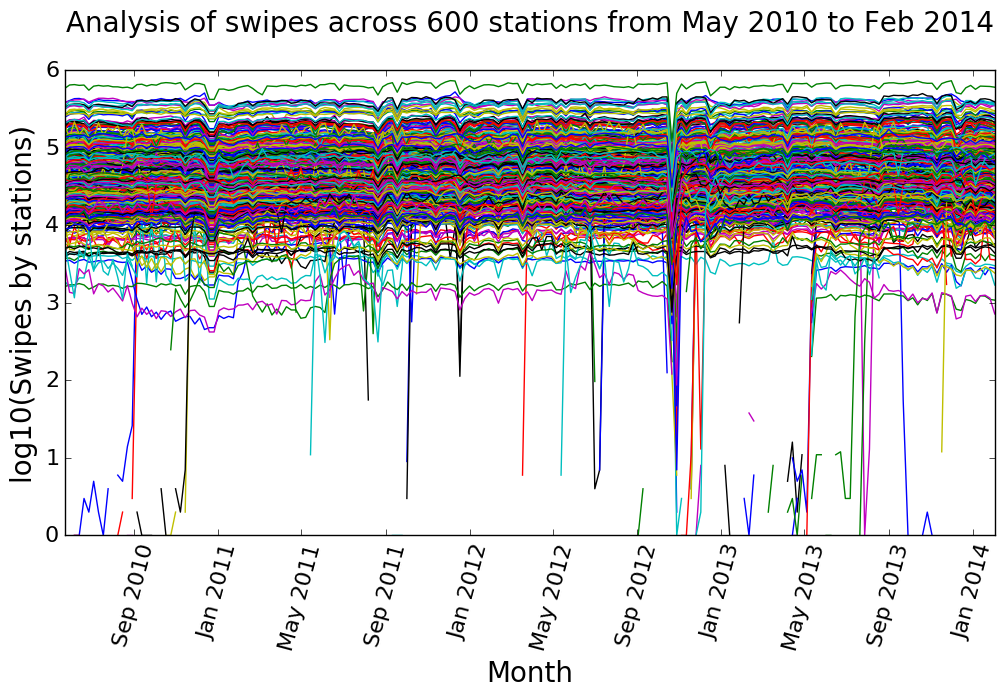

In [10]:
#Plotting the data
figure = pl.figure(figsize=(12, 6))
pl.plot(date, log10(swipes_by_stations_pd.T), '-')
pl.xticks(rotation=75, fontsize=16)
pl.yticks(fontsize=16)
pl.xlabel('Month', fontsize=20)
pl.ylabel('log10(Swipes by stations)', fontsize=20)
pl.title('Analysis of swipes across 600 stations from May 2010 to Feb 2014\n', fontsize = 20)

### An observation cannot be made from the cluttered plot as displayed above. In order to make a clear evaluation of the plot I will sum the swipe history across all stations

In [11]:
#Summing the data across all subway stations
total_swipes_by_week = swipes_by_stations_pd.sum()
mean_total_swipes_by_week = total_swipes_by_week.mean()
std_total_swipes_by_week = total_swipes_by_week.std()
threshold = [mean_total_swipes_by_week + 3 * std_total_swipes_by_week, 
             mean_total_swipes_by_week - 3 * std_total_swipes_by_week]
print("The mean is %s, the standard deviation is %s"%(mean_total_swipes_by_week,std_total_swipes_by_week))

The mean is 29781349.8711, the standard deviation is 2991680.90141


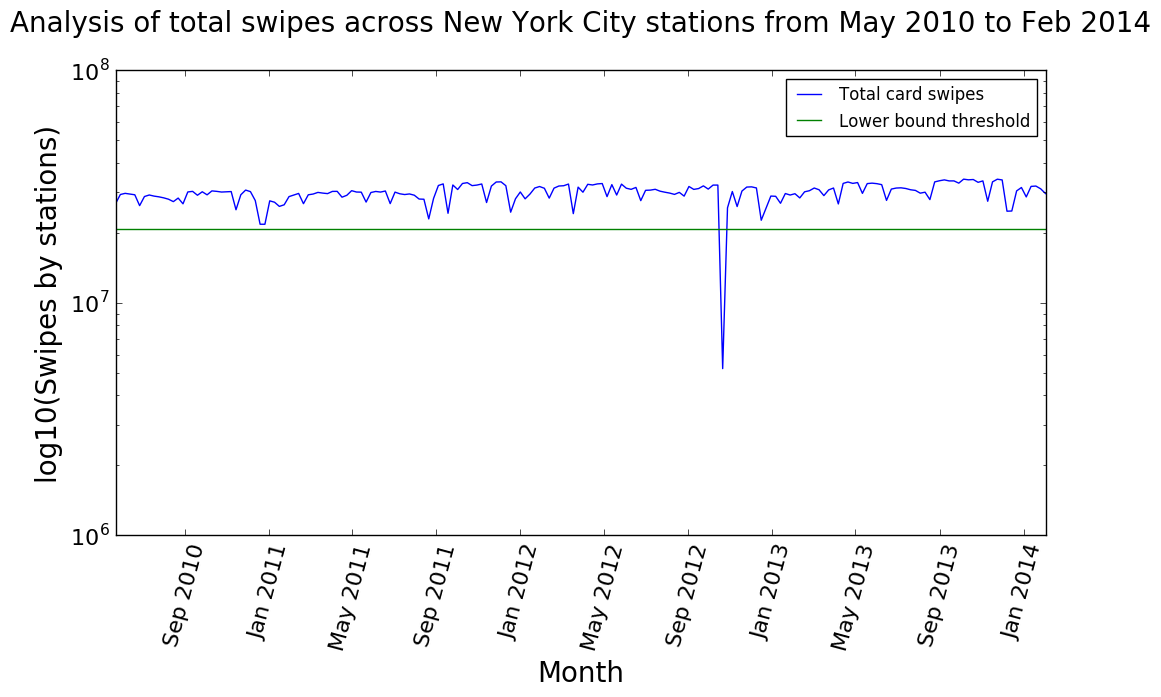

In [12]:
#Replotting the data
ax = total_swipes_by_week.plot(logy = True, figsize=(12,6), label='Total card swipes')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]],[threshold[1], threshold[1]], label = 'Lower bound threshold')
pl.xticks(rotation=75, fontsize=16)
pl.yticks(fontsize=16)
pl.xlabel('Month', fontsize=20)
pl.ylabel('log10(Swipes by stations)', fontsize=20)
pl.title('Analysis of total swipes across New York City stations from May 2010 to Feb 2014\n', fontsize = 20)
pl.legend()

### As observed from the plot, there is a drop in number of swipes across the cardtypes between September 2012 to January 2013. This value crosses the lower threshold of being three standard deviations away from the mean of the time-series and hence we can comfortably conclude that this was a prominent event.
### A preliminary analysis of the archives data suggest this drop in number of swipes was caused due to the MTA System-wide shutdown caused by Hurricane Sandy on Oct 28, 2012.
### http://www.mta.info/news_archives/2012

## Task 2:
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)¶


In [13]:
#Aggregating data by ridetypes
swipes_by_ridetype = np.nansum(mtaRides, axis = 0)
swipes_by_ridetype.shape

(23, 194)

In [189]:
#Creating dataframe
swipes_by_ridetype_pd = pd.DataFrame(swipes_by_ridetype.T, index = date.date)
swipes_by_ridetype_pd = swipes_by_ridetype_pd.T
swipes_by_ridetype_pd.index = ridetype
swipes_by_ridetype_pd.head()

,2010-05-23,2010-05-30,2010-06-06,2010-06-13,2010-06-20,2010-06-27,2010-07-04,2010-07-11,2010-07-18,2010-07-25,...,2013-12-01,2013-12-08,2013-12-15,2013-12-22,2013-12-29,2014-01-05,2014-01-12,2014-01-19,2014-01-26,2014-02-02
10t,11494615.0,12526859.0,12766627.0,12653675.0,12809694.0,11429783.0,12346877.0,12576759.0,12437115.0,12431257.0,...,14604028.0,11344945.0,11223430.0,12864865.0,12904811.0,11932970.0,13139360.0,13189610.0,12500756.0,12459947.0
14d,530524.0,583533.0,586194.0,562602.0,548858.0,455691.0,518187.0,513412.0,512192.0,522569.0,...,781529.0,596341.0,518956.0,664531.0,744990.0,613294.0,713717.0,695134.0,670228.0,679497.0
1d,47801.0,51486.0,51636.0,52063.0,51153.0,46852.0,48963.0,49629.0,49030.0,50376.0,...,62658.0,50820.0,45153.0,56129.0,60429.0,51664.0,57208.0,58771.0,56525.0,55192.0
2t,186551.0,199229.0,199668.0,196389.0,194883.0,175648.0,188467.0,188090.0,186822.0,190528.0,...,193268.0,164607.0,148652.0,177885.0,193547.0,168932.0,189564.0,184239.0,180029.0,179363.0
30d,46808.0,64353.0,56994.0,37429.0,35210.0,46849.0,60225.0,47439.0,32084.0,52171.0,...,56671.0,22623.0,25301.0,67713.0,64867.0,43426.0,47804.0,61101.0,59400.0,46859.0


In [180]:
#Creating list of stationary time series
ridetype_stationary = []
for i in range(len(ridetype)):
    if sm.tsa.adfuller(swipes_by_ridetype_pd.iloc[i])[1] < 0.05:
        ridetype_stationary.append(ridetype[i])

### I am using the ADFuller test to check stationarity of a timeseries. I am checking if the p - value is less than 5 % in order to reject the null hypothesis. The null hypothesis for the test is that there is a presence of a unit root

In [181]:
#List of stationary timeseries
ridetype_stationary

['10t', '2t', '30d', 'ada', 'exp', 'tcmc', 't', 'umlim']

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False).mean()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False).std()


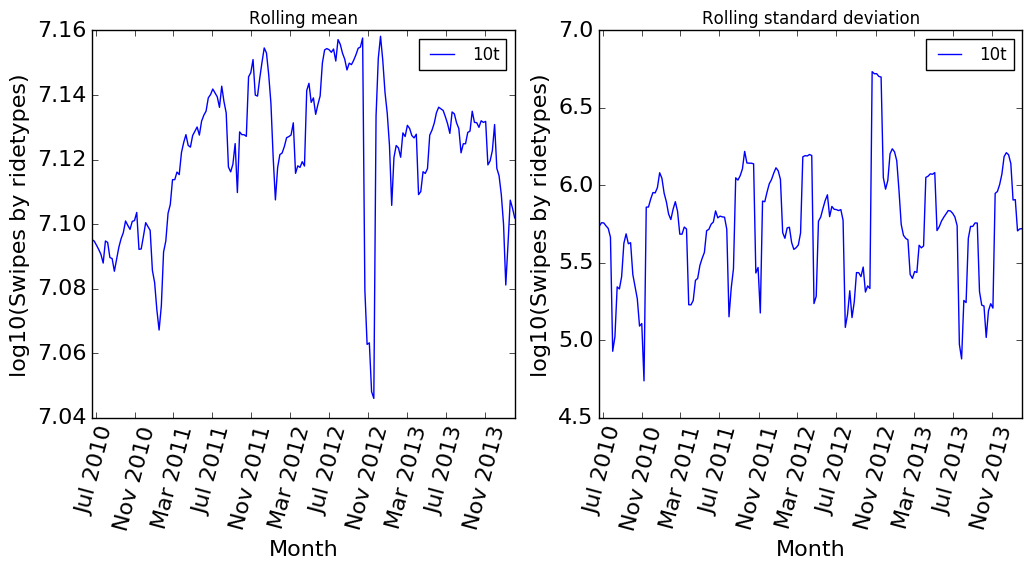

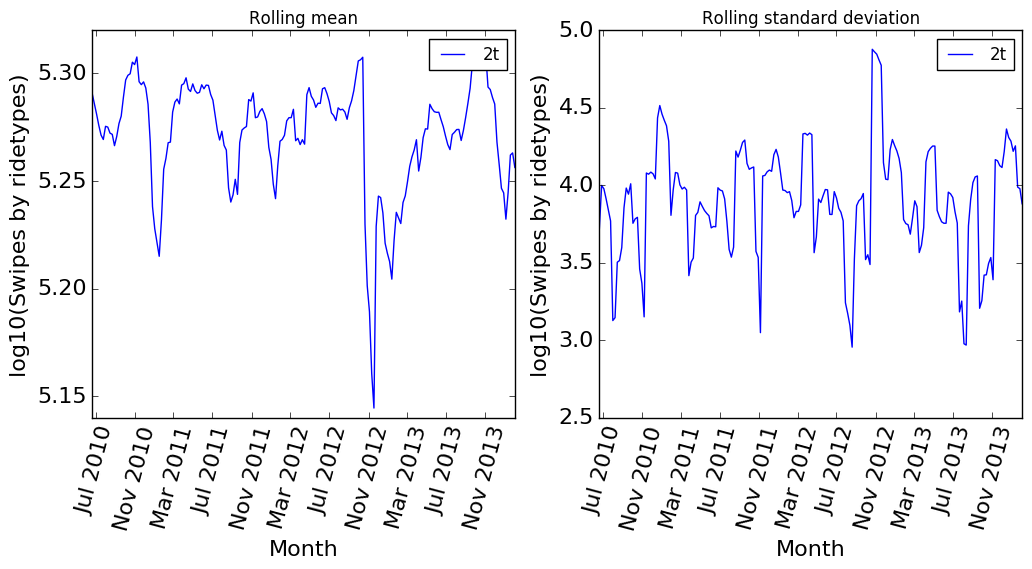

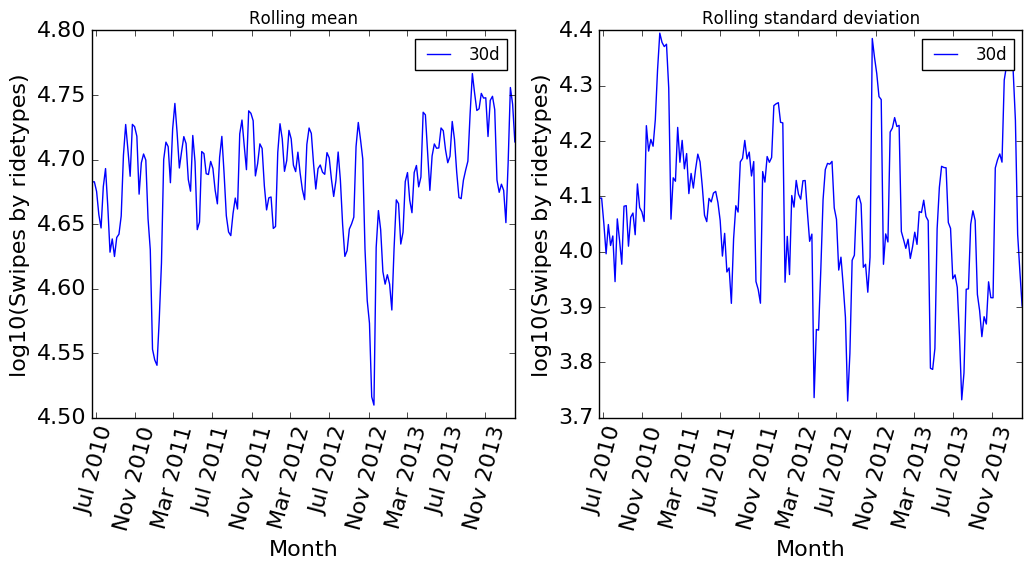

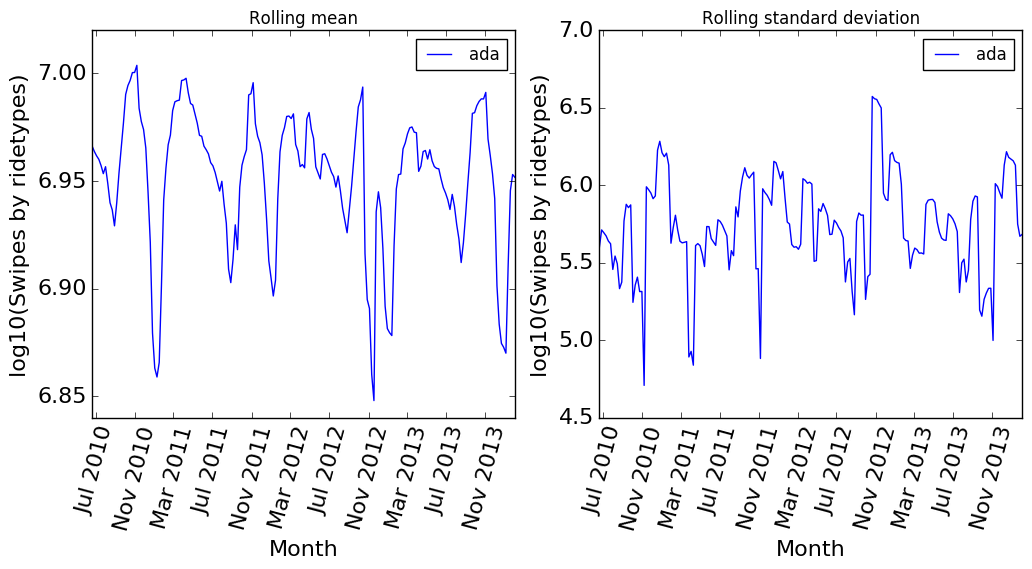

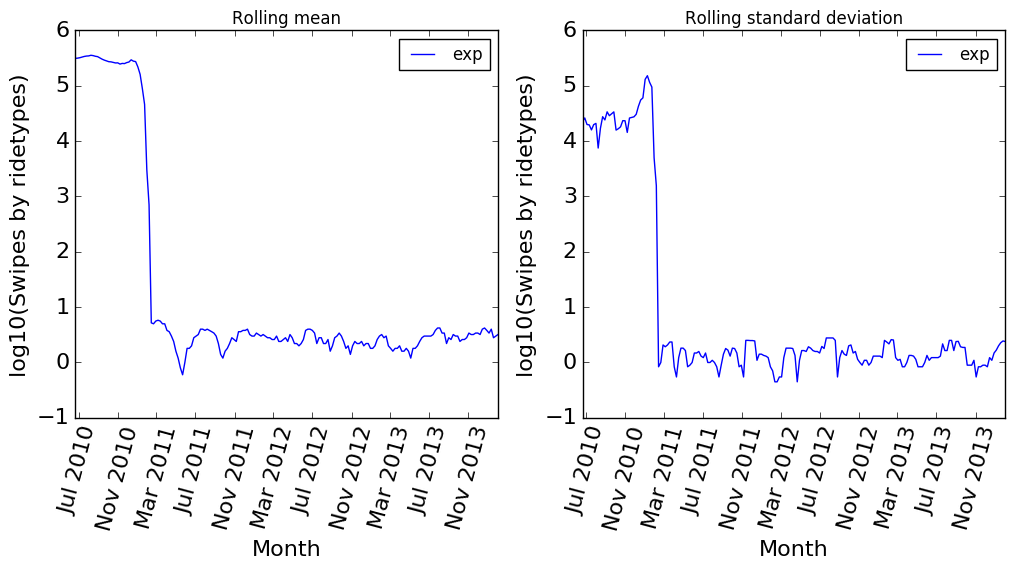

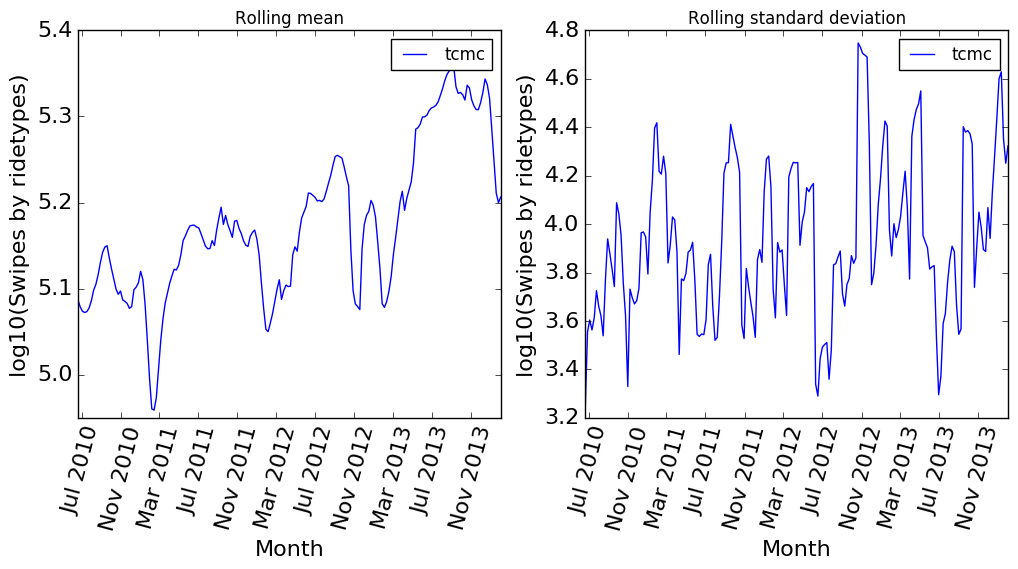

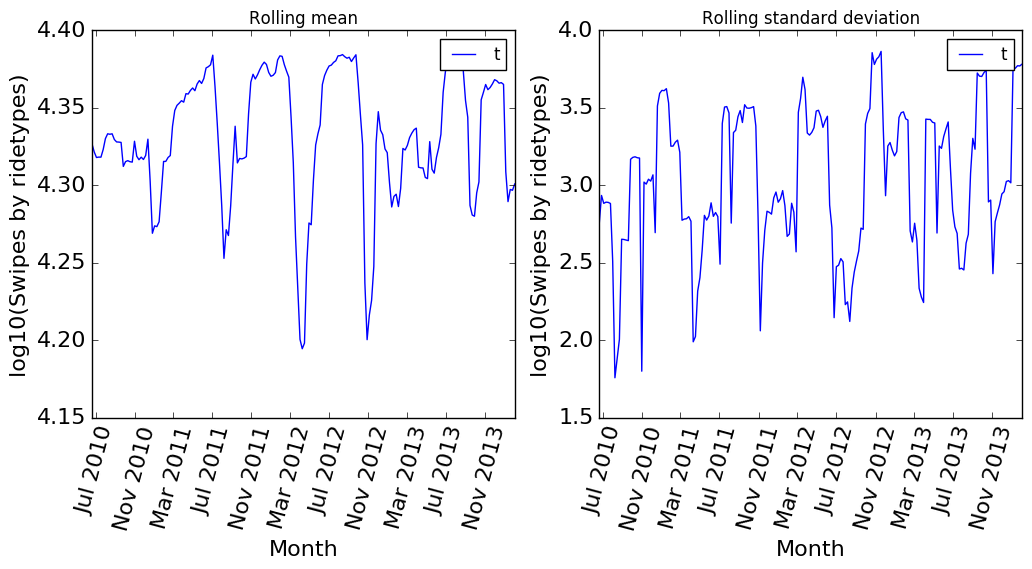

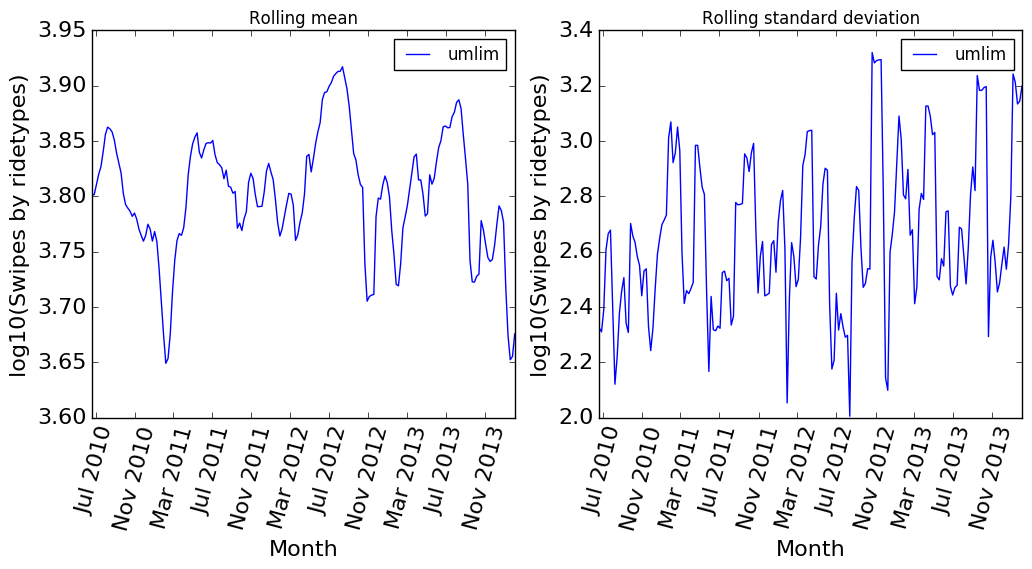

In [251]:
#Plotting rolling mean and rolling variance for stationary timeseries
for i in range(len(ridetype_stationary)):
    fig = plt.figure(figsize = (12,5))
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    
    ax1.plot(date , log10((pd.rolling_mean(swipes_by_ridetype_pd.T , 5)[ridetype_stationary[i]])),\
            label = ridetype_stationary[i])
    plt.sca(ax1)
    plt.xticks(rotation=75, fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Month', fontsize=16)
    plt.ylabel('log10(Swipes by ridetypes)', fontsize=16)
    ax1.legend()
    
    ax2.plot(date, log10((pd.rolling_std(swipes_by_ridetype_pd.T, 5)[ridetype_stationary[i]])), \
            label = ridetype_stationary[i])
    plt.sca(ax2)
    plt.xticks(rotation=75, fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Month', fontsize=16)
    plt.ylabel('log10(Swipes by ridetypes)', fontsize=16)
    ax2.legend()

    ax1.set(title='Rolling mean')
    ax2.set(title='Rolling standard deviation')    

# The above figure is plots of rolling mean and rolling average for total swipes by riderships from May 2010 to Feb 2014